In [ ]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import librosa
import soundfile
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import set_random_seed

import pickle

# Data Loading

In [ ]:
!gdown 1NBPxs5k2UHpfPpmMsADjn85PXOfaz3gW
!unzip -q speech-emotion-recognition-ravdess-data -d /content/dataset

Downloading...
From: https://drive.google.com/uc?id=1NBPxs5k2UHpfPpmMsADjn85PXOfaz3gW
To: /content/speech-emotion-recognition-ravdess-data.zip
100% 78.1M/78.1M [00:02<00:00, 30.9MB/s]


In [ ]:
subdirs = [os.path.join("./dataset", subdir) for subdir in os.listdir("./dataset")]
file_paths = [os.path.join(subdir, wav) for subdir in subdirs for wav in os.listdir(subdir)]
print(f"Scanned {len(file_paths)} audio files")

Scanned 1440 audio files


In [ ]:
file_identifiers = pd.DataFrame([os.path.splitext(os.path.basename(p))[0].split("-") for p in file_paths]).applymap(lambda x : int(x))
print(f"Generated identifiers of shape: {file_identifiers.shape}")

Generated identifiers of shape: (1440, 7)


In [ ]:
df = pd.DataFrame()
df["path"] = file_paths
# Makna setiap identifier dapat dibaca di:
# https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
# Hanya emotion yang diperlukan
df["emotion"] = file_identifiers[2].map({1: "neutral", 2: "calm", 3: "happy", 4: "sad", 5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"})
df["emotional_intensity"] = file_identifiers[3].map({1: "normal", 2: "strong"})

In [ ]:
display(df)

,path,emotion,emotional_intensity
0,./dataset/Actor_08/03-01-05-01-02-02-08.wav,angry,normal
1,./dataset/Actor_08/03-01-08-02-01-01-08.wav,surprised,strong
2,./dataset/Actor_08/03-01-05-01-01-01-08.wav,angry,normal
3,./dataset/Actor_08/03-01-08-02-02-01-08.wav,surprised,strong
4,./dataset/Actor_08/03-01-06-02-02-01-08.wav,fearful,strong
...,...,...,...
1435,./dataset/Actor_12/03-01-08-01-01-02-12.wav,surprised,normal
1436,./dataset/Actor_12/03-01-04-01-01-01-12.wav,sad,normal
1437,./dataset/Actor_12/03-01-08-02-02-01-12.wav,surprised,strong
1438,./dataset/Actor_12/03-01-04-01-02-02-12.wav,sad,normal


# Data Preprocessing
Preprocessing ga langsung di-apply, ditampung dulu dalam fungsi. Diapply semua di bagian terakhir.

## Train Test Split

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
print(f"Train: {train.shape} Test: {test.shape}")

Train: (1152, 3) Test: (288, 3)


## Feature Extraction

In [ ]:
def mfcc(testpath):
    x, sample_rate = soundfile.read(testpath, dtype="float32")
    mfcc = librosa.feature.mfcc(y=x, sr=sample_rate)
    del1 = librosa.feature.delta(mfcc, delta=1)
    del2 = librosa.feature.delta(mfcc, delta=2)
    complete_mfcc = np.vstack((mfcc, del1, del2))
    mfcc_mean = complete_mfcc.mean(axis=1)
    mfcc_max = complete_mfcc.max(axis=1)
    mfcc_min = complete_mfcc.min(axis=1)
    mfcc_std = complete_mfcc.std(axis=1)
    return pd.Series(np.hstack((mfcc_mean, mfcc_max, mfcc_min, mfcc_std)))

In [ ]:
testpath = df["path"].iloc[0]
print(f"Extracting {mfcc(testpath).shape[0]} features from each audio file")

Extracting 240 features from each audio file


In [ ]:
x_train = pd.DataFrame(train["path"].apply(mfcc))
x_test = pd.DataFrame(test["path"].apply(mfcc))

## Relabel

In [ ]:
encoder = LabelBinarizer()
encoder = encoder.fit(df["emotion"])

In [ ]:
y_train = encoder.transform(train["emotion"])
y_test = encoder.transform(test["emotion"])

## Z-Score Normalization

In [ ]:
print(x_train[[0,1,2]].std())

0    99.308998
1    16.549145
2    12.581145
dtype: float32


In [ ]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [ ]:
print(x_train[[0,1,2]].std())

0    1.000434
1    1.000434
2    1.000434
dtype: float32


## Summary

In [ ]:
print(f"X train: {x_train.shape} Y train: {y_train.shape}")
print(f"X test: {x_test.shape} Y test: {y_test.shape}")

X train: (1152, 240) Y train: (1152, 8)
X test: (288, 240) Y test: (288, 8)


# Modelling

In [ ]:
model = Sequential([
    Dropout(0.1),
    Dense(180, activation='relu'),
    Dropout(0.3),
    Dense(120, activation='relu'),
    Dropout(0.3),
    Dense(60, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
set_random_seed(1)

history = model.fit(
    x_train,
    y_train,
    epochs=200,
    validation_data = (x_test, y_test)
)

Epoch 1/200
36/36 [==============================] - 2s 15ms/step - loss: 2.1981 - accuracy: 0.1354 - val_loss: 1.9675 - val_accuracy: 0.2431
Epoch 2/200
36/36 [==============================] - 0s 7ms/step - loss: 1.9956 - accuracy: 0.2274 - val_loss: 1.8894 - val_accuracy: 0.3125
Epoch 3/200
36/36 [==============================] - 0s 5ms/step - loss: 1.9444 - accuracy: 0.2465 - val_loss: 1.8337 - val_accuracy: 0.3160
Epoch 4/200
36/36 [==============================] - 0s 6ms/step - loss: 1.8355 - accuracy: 0.2839 - val_loss: 1.7643 - val_accuracy: 0.3403
Epoch 5/200
36/36 [==============================] - 0s 5ms/step - loss: 1.7855 - accuracy: 0.3064 - val_loss: 1.6859 - val_accuracy: 0.3715
Epoch 6/200
36/36 [==============================] - 0s 5ms/step - loss: 1.7538 - accuracy: 0.3299 - val_loss: 1.6361 - val_accuracy: 0.4167
Epoch 7/200
36/36 [==============================] - 0s 6ms/step - loss: 1.6570 - accuracy: 0.3481 - val_loss: 1.5555 - val_accuracy: 0.4271
Epoch 8/200


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (32, 240)                 0         
                                                                 
 dense (Dense)               (32, 180)                 43380     
                                                                 
 dropout_1 (Dropout)         (32, 180)                 0         
                                                                 
 dense_1 (Dense)             (32, 120)                 21720     
                                                                 
 dropout_2 (Dropout)         (32, 120)                 0         
                                                                 
 dense_2 (Dense)             (32, 60)                  7260      
                                                                 
 dropout_3 (Dropout)         (32, 60)                  0

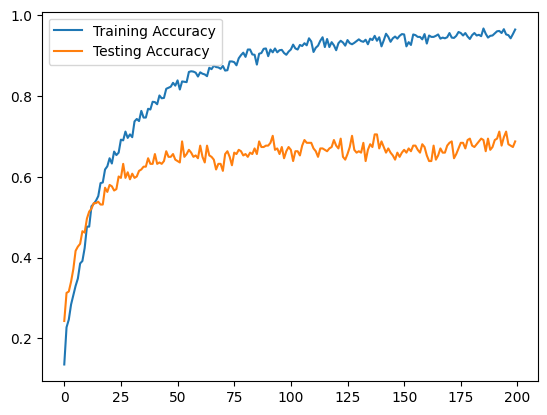

In [ ]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Testing Accuracy")
plt.legend()
plt.show()

In [ ]:
pred = encoder.inverse_transform(model.predict(x_test))

9/9 [==============================] - 0s 8ms/step


In [ ]:
pred

array(['fearful', 'happy', 'disgust', 'happy', 'sad', 'sad', 'disgust',
       'disgust', 'fearful', 'sad', 'disgust', 'fearful', 'angry',
       'happy', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust',
       'surprised', 'disgust', 'calm', 'angry', 'sad', 'neutral',
       'surprised', 'surprised', 'angry', 'surprised', 'surprised',
       'disgust', 'neutral', 'calm', 'neutral', 'surprised', 'happy',
       'surprised', 'fearful', 'calm', 'neutral', 'disgust', 'fearful',
       'angry', 'surprised', 'disgust', 'fearful', 'disgust', 'sad',
       'disgust', 'sad', 'calm', 'surprised', 'disgust', 'happy',
       'disgust', 'disgust', 'disgust', 'angry', 'fearful', 'neutral',
       'calm', 'neutral', 'disgust', 'neutral', 'calm', 'disgust',
       'fearful', 'sad', 'calm', 'surprised', 'fearful', 'sad', 'calm',
       'surprised', 'happy', 'happy', 'happy', 'neutral', 'calm',
       'surprised', 'angry', 'happy', 'angry', 'calm', 'disgust', 'angry',
       'happy', 'calm', 'sur

In [ ]:
result = pd.DataFrame()
result["pred"] = pred
result["actual"] = encoder.inverse_transform(y_test)
result

,pred,actual
0,fearful,fearful
1,happy,sad
2,disgust,disgust
3,happy,happy
4,sad,neutral
...,...,...
283,fearful,happy
284,fearful,fearful
285,fearful,fearful
286,sad,sad


# Evaluation

In [ ]:
print(classification_report(result["actual"], result["pred"]))

              precision    recall  f1-score   support

       angry       0.86      0.73      0.79        41
        calm       0.73      0.86      0.79        37
     disgust       0.70      0.75      0.73        44
     fearful       0.61      0.79      0.69        28
       happy       0.62      0.57      0.59        42
     neutral       0.62      0.65      0.63        20
         sad       0.53      0.50      0.51        36
   surprised       0.81      0.65      0.72        40

    accuracy                           0.69       288
   macro avg       0.68      0.69      0.68       288
weighted avg       0.69      0.69      0.69       288



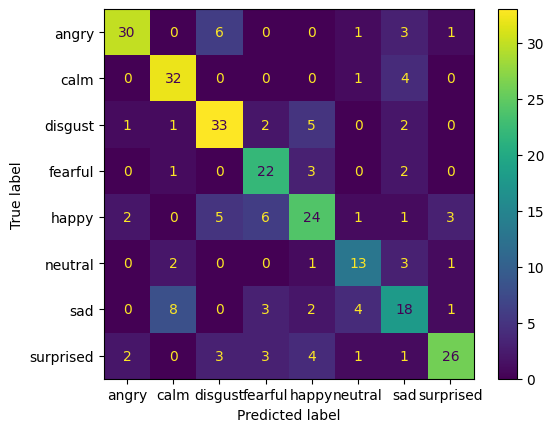

In [ ]:
ConfusionMatrixDisplay.from_predictions(result["actual"], result["pred"])
plt.show()

# Save Models

In [ ]:
model.save("models/ann.h5")
with open("models/encoder.pickle", "wb") as f:
    pickle.dump(encoder, f)
with open("models/scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)